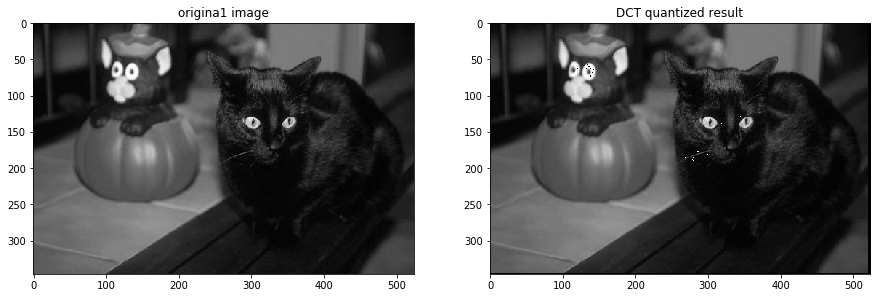

C:\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: black cat2_jpeg.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:171: UserWarning: Downcasting uint32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in ulong_scalars


PSNR1 32.334190726304534 dB


In [2]:
from scipy.fftpack import dct,idct
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

def dct2(block):
    return dct(dct(block.T, norm = 'ortho').T, norm = 'ortho')

def idct2(block):
    return idct(idct(block.T, norm = 'ortho').T, norm = 'ortho')

def quanStep(block,quanTable):
    dct_block = dct2(block.T.T)
    qdct_block = np.zeros((8,8))
    for i in range(0,8):
        for j in range(0,8):
            qdct_block[i,j] = np.round(float(dct_block[i,j]/(quanTable[i,j])))*quanTable[i,j]
    ret_qdct_block = np.uint8(idct2(qdct_block.T.T))
    return ret_qdct_block

def Dis_Res(block):
    rows,cols=block.shape
    for i in range(0,rows):
        for j in range(0,cols):
            print(block[i][j])
        print()
        
        
def imageDCT2D(image,quanTable):
    rows,cols=image.shape
    dct_image = np.zeros((rows,cols))
    row_times = np.uint8(rows/8)
    col_times = np.uint8(cols/8)
    
    for i  in range(0,row_times):
        for j in range(0,col_times):
            block = image[8*i+0:8*i+8,8*j+0:8*j+8]
            qblock = quanStep(block,quanTable)
            dct_image[8*i+0:8*i+8,8*j+0:8*j+8] = qblock;
            
    return dct_image
    
def PSNR_Cal2(image,qimage):
    rows,cols,dims=image.shape
    dif = 0.0
    for i in range(0,rows):
        for j in range(0,cols):
            for k in range(0,dims):
                dif = dif + (image[i][j][k] -qimage[i][j][k])*(image[i][j][k]-qimage[i][j][k])
    MSE = dif/ (rows*cols)
    PSNR = 10 *np.log10(255*255/MSE)
    return PSNR

def PSNR_Cal(image,qimage):
    rows,cols=image.shape
    dif = 0.0
    for i in range(0,rows):
        for j in range(0,cols):
            dif = dif + (image[i][j] -qimage[i][j])*(image[i][j]-qimage[i][j])
    MSE = dif / (rows*cols)
    PSNR = 10 * np.log10(255*255/MSE)
    return PSNR

def QF(QT,qu):
    QT2 = np.zeros((8,8))
    if(qu <= 0):
        qu = 1
    if(qu>100):
        qu = 100
        
    if(qu<50):
        qu = 5000/qu
    else:
        qu = 200-qu*2
    for i in range(0,8):
        for j in range(0,8):
            QT2[i][j] = QT[i][j]*qu/100
            
    return QT2


img=io.imread('black cat2.jpg')
plt.figure(num=0,figsize=(15,15))
quality = 90

quanTable = np.array([[16,11,10,16,24,40,51,61],
[12,12,14,19,26,58,60,55],
[14,13,16,24,40,57,69,56],
[14,17,22,29,51,87,80,62],
[18,22,37,56,68,109,103,92],
[24,35,55,64,81,104,113,92],
[49,64,78,87,103,121,120,101],
[72,92,95,98,112,100,103,99]])

quanTable2 = np.int64(QF(quanTable , quality))

plt.subplot(1,2,1)
plt.title('origina1 image')
plt.imshow(img, cmap='gray')

img2 = np.uint32(imageDCT2D(img,quanTable2))

plt.subplot(1,2,2)
plt.title('DCT quantized result')
plt.imshow(img2, cmap='gray')
plt.show()
io.imsave('black cat2_jpeg.jpg',img2)
print('PSNR1',PSNR_Cal(img,img2),'dB')